In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

file_path = "/content/drive/MyDrive/BreakfastActivityRecognition.zip"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [3]:
import os
import cv2
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3

In [4]:
train_dir = '/content/dataset/Breakfast Action Recognition/train'
valid_dir = '/content/dataset/Breakfast Action Recognition/valid'

def collect_filenames_and_labels(directory):
    video_paths = []
    labels = []
    for person_folder in os.listdir(directory):
        person_path = os.path.join(directory, person_folder)
        if os.path.isdir(person_path):
            for filename in os.listdir(person_path):
                video_path = os.path.join(person_path, filename)
                video_paths.append(video_path)
                label = filename.split('_')[1].split('.')[0]
                labels.append(label)
    return video_paths, labels

train_video_paths, train_labels = collect_filenames_and_labels(train_dir)
valid_video_paths, valid_labels = collect_filenames_and_labels(valid_dir)

In [5]:
print(len(train_video_paths), len(train_labels))
print(len(valid_video_paths), len(valid_labels))

377 377
38 38


In [6]:
def extract_frames(video_path, num_frames=16, resize_dim=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize_dim)
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    return frames

In [7]:
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        if random.random() < 0.5:
            frame = cv2.flip(frame, 1)
        if random.random() < 0.5:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        augmented_frames.append(frame)
    return augmented_frames

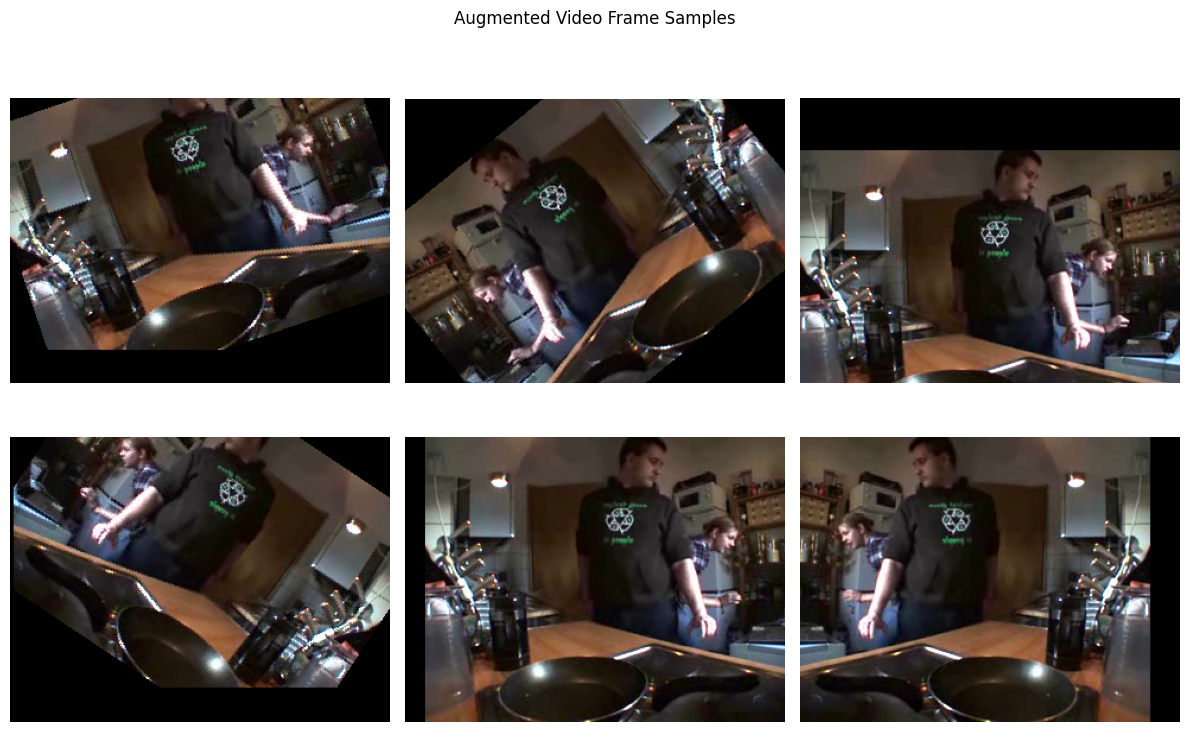

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageOps

# Function to perform random augmentation on a frame
def augment_frame(frame):
    image = Image.fromarray(frame)

    # Random rotation
    if random.choice([True, False]):
        image = image.rotate(random.uniform(-40, 40))

    # Random horizontal flip
    if random.choice([True, False]):
        image = ImageOps.mirror(image)

    # Random width shift
    if random.choice([True, False]):
        shift = random.uniform(-0.2, 0.2) * image.width
        image = image.transform(image.size, Image.AFFINE, (1, 0, shift, 0, 1, 0))

    # Random height shift
    if random.choice([True, False]):
        shift = random.uniform(-0.2, 0.2) * image.height
        image = image.transform(image.size, Image.AFFINE, (1, 0, 0, 0, 1, shift))

    # Random zoom
    if random.choice([True, False]):
        zoom_factor = random.uniform(0.8, 1.2)
        image = image.resize((int(image.width * zoom_factor), int(image.height * zoom_factor)), Image.LANCZOS)
        image = image.crop((0, 0, image.width, image.height))

    return np.array(image)

# Path to the video file
video_path = '/content/dataset/Breakfast Action Recognition/train/P03/P03_coffee.avi'  # Replace with your video path

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Read the first frame to get video properties
ret, frame = cap.read()
if not ret:
    print("Error reading the first frame")
    cap.release()
    exit()

# Prepare for visualization
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

# Process and visualize a few frames
for i in range(6):
    ret, frame = cap.read()
    if not ret:
        break

    augmented_frame = augment_frame(frame)

    # Display the augmented frame
    axs[i].imshow(cv2.cvtColor(augmented_frame, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.suptitle('Augmented Video Frame Samples')
plt.tight_layout()
plt.show()

# Release the video capture object
cap.release()


In [ ]:
class AugmentedVideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=8, num_frames=16, resize_dim=(224, 224), shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.resize_dim = resize_dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.video_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_video_paths = [self.video_paths[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]

        X, y = self.__data_generation(batch_video_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_video_paths, batch_labels):
        X = np.empty((self.batch_size, self.num_frames, *self.resize_dim, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=int)

        for i, (video_path, label) in enumerate(zip(batch_video_paths, batch_labels)):
            frames = extract_frames(video_path, self.num_frames, self.resize_dim)
            if len(frames) == self.num_frames:
                frames = augment_frames(frames)
                X[i,] = frames
                y[i] = label

        return X, y

In [ ]:
# def preprocess_data(video_paths, labels, num_frames=16):
#     X = []
#     for video_path in video_paths:
#         frames = extract_frames(video_path, num_frames)
#         if len(frames) == num_frames:
#             X.append(frames)
#     X = np.asarray(X)
#     y = np.asarray(labels)
#     return X, y

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_labels + valid_labels)

print("Class labels:", encoder.classes_)
print("Class number:",len(encoder.classes_))
encoded_train_labels = encoder.transform(train_labels)
encoded_valid_labels = encoder.transform(valid_labels)

Class labels: ['cereals' 'coffee' 'friedegg' 'juice' 'milk' 'pancake' 'salat' 'sandwich'
 'scrambledegg' 'tea']
Class number: 10


In [ ]:
batch_size = 8

train_generator = AugmentedVideoDataGenerator(train_video_paths, encoded_train_labels, batch_size=batch_size)
valid_generator = AugmentedVideoDataGenerator(valid_video_paths, encoded_valid_labels, batch_size=batch_size, shuffle=False)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM

def build_3dcnn_model(input_shape=(16, 224, 224, 3), num_classes=len(encoder.classes_)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        TimeDistributed(base_model, input_shape=input_shape),
        TimeDistributed(GlobalAveragePooling2D()),
        TimeDistributed(BatchNormalization()),
        LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)),
        LSTM(256, kernel_regularizer=l2(0.01)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_3dcnn_model()

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
checkpoint_dir = '/content/drive/My Drive/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback])

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 15.1493 - accuracy: 0.0824
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /content/drive/My Drive/checkpoints/model_epoch_01_val_acc_0.12.h5
47/47 [==============================] - 51s 591ms/step - loss: 15.1493 - accuracy: 0.0824 - val_loss: 9.2401 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 7.0595 - accuracy: 0.1410
Epoch 2: val_accuracy improved from 0.12500 to 0.15625, saving model to /content/drive/My Drive/checkpoints/model_epoch_02_val_acc_0.16.h5
47/47 [==============================] - 19s 407ms/step - loss: 7.0595 - accuracy: 0.1410 - val_loss: 5.7595 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 4.9616 - accuracy: 0.1862
Epoch 3: val_accuracy did not improve from 0.15625
47/47 [==============================] - 18s 380ms/step - loss: 4.9616 - accuracy: 0.1862 - val_loss

In [ ]:
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

4/4 [==============================] - 1s 287ms/step - loss: 3.0903 - accuracy: 0.1562
Validation Accuracy: 15.62%


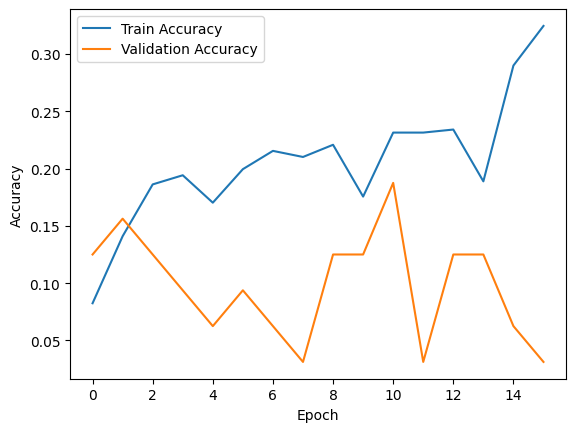

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
model.load_weights("/content/model_weights.h5")

In [ ]:
def load_and_predict(video_path, model, weights_path, resize_dim=(224, 224)):
    video_frames = extract_frames(video_path, num_frames=16, resize_dim=(224, 224))
    video_frames = np.expand_dims(video_frames, axis=0)
    predictions = model.predict(video_frames)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

activity_dict = {
    0: 'cereals', 1: 'coffee', 2: 'friedegg', 3: 'juice', 4: 'milk',
    5: 'pancake', 6: 'salat', 7: 'sandwich', 8: 'scrambledegg', 9: 'tea'
}
test_video_path = '/content/dataset/Breakfast Action Recognition/valid/P50/P50_cereals.avi'

predicted_class_lstm = load_and_predict(test_video_path, model, 'model_weights.h5', resize_dim=(224, 224))
predicted_activity = activity_dict.get(predicted_class_lstm[0], "Unknown")
print(f"Predicted activity by LSTM model: {predicted_activity}")


1/1 [==============================] - 0s 35ms/step
Predicted activity by LSTM model: tea


In [ ]:
model.load_weights("/content/lstm_model_weights.h5")

In [ ]:
def load_and_predict(video_path, model, weights_path, resize_dim=(224, 224)):
    video_frames = extract_frames(video_path, num_frames=16, resize_dim=(224, 224))
    video_frames = np.expand_dims(video_frames, axis=0)
    predictions = model.predict(video_frames)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

activity_dict = {
    0: 'cereals', 1: 'coffee', 2: 'friedegg', 3: 'juice', 4: 'milk',
    5: 'pancake', 6: 'salat', 7: 'sandwich', 8: 'scrambledegg', 9: 'tea'
}
test_video_path = '/content/dataset/Breakfast Action Recognition/valid/P50/P50_juice.avi'

predicted_class_lstm = load_and_predict(test_video_path, model, '/content/lstm_model_weights.h5', resize_dim=(224, 224))
predicted_activity = activity_dict.get(predicted_class_lstm[0], "Unknown")
print(f"Predicted activity by LSTM model: {predicted_activity}")

1/1 [==============================] - 0s 32ms/step
Predicted activity by LSTM model: cereals


In [ ]:
model.load_weights("/content/model_weights.h5")

1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
[[0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]]
Accuracy: 0.3333333333333333
Precision: 0.2037037037037037
Recall: 0.3333333333333333
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_tea.avi: tea
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_salat.avi: milk
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_juice.avi: milk
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_friedegg.avi: friedegg
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_sandwich.avi: sandwich
Predicted activity for /content/dataset/Breakfast Action Recognition/valid/P48/P48_milk.avi: tea
Predicted activity for /content/dataset/Breakfast A

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


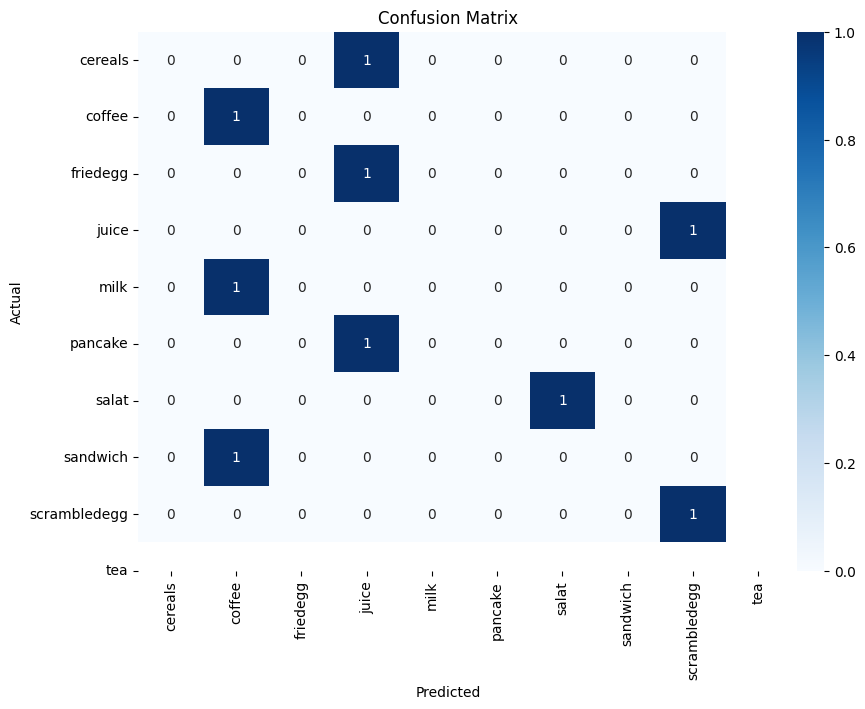

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

test_videos=[('/content/dataset/Breakfast Action Recognition/valid/P48/P48_tea.avi',9),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_salat.avi',6),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_juice.avi',3),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_friedegg.avi',2),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_sandwich.avi',7),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_milk.avi',4),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_pancake.avi',5),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_scrambledegg.avi',8),
 ('/content/dataset/Breakfast Action Recognition/valid/P48/P48_cereals.avi',0)]


# Collect actual and predicted labels
actual_labels = []
predicted_labels = []

for video_path, actual_label in test_videos:
    predicted_class = load_and_predict(video_path, model, '/content/model_weights.h5', resize_dim=(224, 224))
    predicted_labels.append(predicted_class[0])
    actual_labels.append(actual_label)

# Calculate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Optional: Print predicted activities
for video_path, predicted_class in zip(test_videos, predicted_labels):
    predicted_activity = activity_dict.get(predicted_class, "Unknown")
    print(f"Predicted activity for {video_path[0]}: {predicted_activity}")

# Draw the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_dict.values(), yticklabels=activity_dict.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()